In [1]:
#import necessary libraries
import pandas as pd
import re
import torch
import collections
import numpy as np
import json
import time
from tqdm.notebook import tqdm
import torch.nn as nn

#output all items, not just last one
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

#set device
if torch.cuda.is_available():
    device= "cuda"
else:
    device = "cpu"  

In [2]:
#define Articles dataset class for easy sampling, iteration, and weight creating
class Articles(torch.utils.data.Dataset):
    def __init__(self, json_file):
        super().__init__()
        with open(json_file, "r") as data_file:
            self.examples = json.loads(data_file.read())
        self.tokenize()
    
    def __getitem__(self, idx):
        return self.examples[idx]
    
    def __len__(self):
        return len(self.examples)
    
    def tokenize(self):
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = re.findall('[\w]+', self.examples[idx]['text'].lower())
            self.examples[idx]['title'] = re.findall('[\w]+', self.examples[idx]['title'].lower())
    
    def create_weighted_sampler(self):
        prob = np.zeros(len(self))
        positive = sum(example['longform'] == 0 for example in self.examples)
        negative = len(self) - positive
        for idx, example in enumerate(self.examples):
            if example['longform'] == 0:
                prob[idx] = (positive/(len(self)))
            else:
                prob[idx] = (negative/(len(self)))
        return torch.utils.data.WeightedRandomSampler(weights=prob, num_samples=len(self), replacement=True)
    
    def create_dictionaries(self):
        counter = collections.Counter()
        url_counter = collections.Counter()
        urls = []

        for example in self.examples:
            counter.update(example['text'])
            counter.update(example['title'])
            urls.append(example['url'])

        url_counter.update(urls)
        word_to_id = {word: id for id, word in enumerate(counter.keys())}
        article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
        return word_to_id, article_to_id
    
    def map_items(self, word_to_id, url_to_id):
        words = []
        articles = []
        labels = []
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = [word_to_id.get(word, len(word_to_id)) for word in example['text']]
            self.examples[idx]['title'] = [word_to_id.get(word, len(word_to_id)) for word in example['title']]
            self.examples[idx]['url'] = url_to_id.get(example['url'])

In [3]:
#function to create dictionaries for words and urls for all datasets at once
def create_merged_dictionaries(all_examples):
    counter = collections.Counter()
    url_counter = collections.Counter()
    urls = []

    for example in all_examples:
        counter.update(example['text'])
        counter.update(example['title'])
        urls.append(example['url'])

    url_counter.update(urls)
    word_to_id = {word: id for id, word in enumerate(counter.keys())}
    article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
    return word_to_id, article_to_id

In [5]:
#load datasets
train_data = Articles("final-data/train.json")
test_data = Articles("final-data/test.json")
val_data = Articles("final-data/validate.json")
adv_data = Articles("adversarial-data/adv-data.json")
browser_data = Articles("browser-data/browser-data.json")

print("Data Loaded")

Data Loaded


In [6]:
#create dictionaries from all datasets
examples = train_data.examples+test_data.examples+val_data.examples+adv_data.examples+browser_data.examples
final_word_ids,final_url_ids= create_merged_dictionaries(examples)

print("Dictionaries Created")

Dictionaries Created


In [7]:
#map items in dataset using dictionary keys (convert words and urls to numbers for the model)
for dataset in [train_data, test_data, val_data, adv_data, browser_data]:
    dataset.map_items(final_word_ids, final_url_ids);
    
print("Items mapped")

Items mapped


In [8]:
#save dictionary files for future use and ease of access
with open("dictionaries/word_dictionary.json", "w") as file:
    json.dump(final_word_ids, file)

with open("dictionaries/article_dictionary.json", "w") as file:
    json.dump(final_url_ids, file)

In [31]:
#define model which uses a simple dot product with publication and word embeddings to calculate logits
class InnerProduct(nn.Module):
    def __init__(self, n_publications, n_articles, n_attributes, emb_size, sparse, use_article_emb):
        super().__init__()
        self.emb_size = emb_size
        self.publication_embeddings = nn.Embedding(n_publications, emb_size, sparse=sparse)
        self.publication_bias = nn.Embedding(n_publications, 1, sparse=sparse)
        self.attribute_emb_sum = nn.EmbeddingBag(n_attributes, emb_size, mode='mean', sparse=sparse)
        self.attribute_bias_sum = nn.EmbeddingBag(n_attributes, 1, mode='sum', sparse=sparse)
        self.use_article_emb = use_article_emb
        if use_article_emb:
            self.article_embeddings = nn.Embedding(n_articles, emb_size, sparse=sparse)
            self.article_bias = nn.Embedding(n_articles, 1, sparse=sparse)
        self.use_article_emb = use_article_emb

    def reset_parameters(self):
        for module in [self.publication_embeddings, self.attribute_emb_sum]:
            scale = 0.07
            nn.init.uniform_(module.weight, -scale, scale)
        for module in [self.publication_bias, self.attribute_bias_sum]:
            nn.init.zeros_(module.weight)
        if self.use_article_emb:
            for module in [self.article_embeddings, self.article_bias]:
            # initializing article embeddings to zero to allow large batch sizes
            # nn.init.uniform_(module.weight, -scale, scale)
                nn.init.zeros_(module.weight)

    def forward(self, publications, articles, word_attributes, attribute_offsets, pairwise=False, return_intermediate=False):
        publication_emb = self.publication_embeddings(publications)
        attribute_emb = self.attribute_emb_sum(word_attributes, attribute_offsets)
        if self.use_article_emb:
            article_and_attr_emb = self.article_embeddings(articles) + attribute_emb
        else:
            article_and_attr_emb = attribute_emb
        attr_bias = self.attribute_bias_sum(word_attributes, attribute_offsets)
        publication_bias = self.publication_bias(publications)
        if pairwise:
          # for every publication, compute inner product with every article
          # (publications, emb_size) x (emb_size, articles) -> (publications, articles)
            inner_prod = publication_emb @ article_and_attr_emb.t()
          # broadcasting across publication dimension
            logits = inner_prod + publication_bias
          # broadcast across article dimension
            logits += attr_bias.t()
            if self.use_article_emb:
                logits += self.article_bias(articles).t()
        else:
              # for every publication, only compute inner product with corresponding minibatch element
              # (batch_size, 1, emb_size) x (batch_size, emb_size, 1) -> (batch_size, 1)
              # logits = torch.bmm(publication_emb.view(-1, 1, self.emb_size), 
              #                    (article_and_attr_emb).view(-1, self.emb_size, 1)).squeeze()
            inner_prod = (publication_emb * article_and_attr_emb).sum(-1)
            logits = inner_prod + attr_bias.squeeze() + publication_bias.squeeze()
            if self.use_article_emb:
                logits += self.article_bias(articles).squeeze()
        if return_intermediate:
            return logits, publication_emb, attribute_emb
        else:
            return logits
        

In [32]:
#define function to return necessary data for dataloader to pass into model
def collate_fn(examples):
    words = []
    articles = []
    labels = []
    for example in examples:
        words.append(list(set(example['text'])))
        articles.append(example['url'])
        labels.append(example['longform'])
    num_words = [len(x) for x in words]
    words = np.concatenate(words, axis=0)
    word_attributes = torch.tensor(words, dtype=torch.long)
    articles = torch.tensor(articles, dtype=torch.long)
    num_words.insert(0,0)
    num_words.pop(-1)
    attribute_offsets = torch.tensor(np.cumsum(num_words), dtype=torch.long)
    publications = torch.tensor([0])
    labels = torch.tensor(labels, dtype=torch.float)
    return publications, articles, word_attributes, attribute_offsets, labels

In [33]:
#create weights for dataset samples to ensure even batches then wrap with batchsampler
train_weight_sampler = train_data.create_weighted_sampler()

train_batch_sampler = torch.utils.data.BatchSampler(train_weight_sampler, 64, drop_last=True)

In [34]:
#create dataloaders for iterable data when training and testing recall
train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, collate_fn=collate_fn, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), collate_fn=collate_fn, pin_memory=True)

browser_loader = torch.utils.data.DataLoader(browser_data, batch_size=len(browser_data), collate_fn=collate_fn, pin_memory=True)

adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=len(adv_data), collate_fn=collate_fn, pin_memory=True)

In [35]:
#initialize model, loss, and optimizer
kwargs = dict(n_publications=1, 
              n_articles=len(final_url_ids), 
              n_attributes=len(final_word_ids), 
              emb_size=100, sparse=False, 
              use_article_emb=False)
model = InnerProduct(**kwargs)
model.reset_parameters()
model.to(device)

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4,momentum=0.9)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

In [36]:
#function that allows for infinite iteration over training batches
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [37]:
#generate validation batch information prior to running loop as data is all collected in one batch
val_batch = next(iter(val_loader))
val_publications, val_articles, val_word_attributes, val_attribute_offsets, val_labels = val_batch
val_publications = val_publications.to(device)
val_articles = val_articles.to(device)
val_word_attributes = val_word_attributes.to(device)
val_attribute_offsets = val_attribute_offsets.to(device)
val_labels = val_labels.to(device)

In [38]:
model.train() # turn on training mode
check=True
#training loop with validation checks every 50 steps and final validation recall calculated after 400 steps
while check: 
    for step,batch in enumerate(tqdm(cycle(train_loader))):
        optimizer.zero_grad();
        publications, articles, word_attributes, attribute_offsets, labels = batch
        publications = publications.to(device)
        articles = articles.to(device)
        word_attributes = word_attributes.to(device)
        attribute_offsets = attribute_offsets.to(device)
        labels = labels.to(device)
        logits = model(publications, articles, word_attributes, attribute_offsets)
        L = loss(logits, labels)
        L.backward();
        optimizer.step();
        
        if step % 50 == 0 and step % 400 != 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            correct_10=0
            correct_100=0
            for i in range(0, 100):
                if val_labels[indices[i]] == 1:
                    if i < 10: 
                        correct_10 += 1
                    correct_100 += 1
            print("Top 10: ", correct_10, "/10 or ", (correct_10*10), "%")
            print("Top 100: ", correct_100, "/100 or", correct_100, "%")
            model.train();
        
        if step != 0 and step % 400 == 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            df = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
            links = list(final_url_ids.keys())
            for i in range(0, 1000):
                example = val_data[indices[i]]
                prediction = sorted_preds[i].item()
                text = []
                for x in example['title']:
                    text.append(next((word for word, numero in final_word_ids.items() if numero == x), None))
                    title = ""
                for word in text:
                    title += word
                    title += " "
                unique_text = list(set(example['text']))
                url = links[example['url']]
                longform = example['longform']
                df.loc[i] = [title, url, unique_text, longform, prediction]
            df.head()
            df.to_csv("results/validation/top-1000.csv")
            check=False
            break

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  9 /10 or  90 %
Top 100:  56 /100 or 56 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  9 /10 or  90 %
Top 100:  57 /100 or 57 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

,title,url,text,longform,prediction
0,the transformation of johnny spain,http://www.chipbrown.net/articles/spain.htm,"[0, 3, 4, 7, 9, 11, 12, 8206, 15, 114706, 22, ...",1,14.662098
1,flesh and blood,http://www.texasmonthly.com/story/flesh-and-blood,"[0, 3, 4, 5, 7, 8199, 9, 11, 12, 13, 15, 22, 2...",1,12.607406
2,the torture colony,http://www.theamericanscholar.org/the-torture-...,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 21, 22, 23...",1,12.330726
3,the endless odyssey of patrick henry polk,http://www.texasmonthly.com/story/endless-odys...,"[0, 1, 3, 4, 16387, 7, 8, 9, 11, 16396, 12, 13...",1,12.292751
4,frank sinatra has a cold,http://long.fm/ynpjOu,"[0, 1, 49154, 3, 4, 7, 8199, 9, 8202, 11, 12, ...",1,12.134419


In [39]:
#generate adversarial batch information prior as data is all collected in one batch
adv_batch = next(iter(adv_loader))
adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets, adv_labels = adv_batch
adv_publications = adv_publications.to(device)
adv_articles = adv_articles.to(device)
adv_word_attributes = adv_word_attributes.to(device)
adv_attribute_offsets = adv_attribute_offsets.to(device)
adv_labels = adv_labels.to(device)

In [40]:
#generate predictions on adversarial set and determine logits
model.eval()
adv_preds = model(adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets)
adv_sorted_preds, locations = torch.sort(adv_preds, descending=True)
adv_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = adv_data[locations[i]]
    prediction = adv_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    adv_sort.loc[i] = [title, url, short_text, longform, prediction]
    adv_sort.to_csv("results/adversarial/top-1000.csv")
adv_sort.head()
len(adv_sort[adv_sort.url.str.contains("rollingstone")])

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

,title,url,text,longform,prediction
0,the porch pirate of potrero hill can t believe...,https://www.theatlantic.com/technology/archive...,"[0, 1, 3, 4, 7, 8199, 9, 12, 13, 14, 15, 32782...",0,17.649719
1,the strange and mysterious death of mrs jerry ...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...",0,15.444338
2,j paul getty iii exclusive 1974 interview with...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 11, 12, 13, 15, 22, 23, 25,...",0,12.462430
3,cult killing kids in the dark,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 24577, 3, 4, 7, 9, 11, 12, 13, 14, 15, ...",0,11.014772
4,the lost years and last days of david foster w...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 8198, 7, 9, 11, 12, 13, 15, 16404...",0,9.809101


371

In [41]:
#generate browser batch information prior as data is all collected in one batch
browser_batch = next(iter(browser_loader))
browser_publications, browser_articles, browser_word_attributes, browser_attribute_offsets, browser_labels = browser_batch
browser_publications = browser_publications.to(device)
browser_articles = browser_articles.to(device)
browser_word_attributes = browser_word_attributes.to(device)
browser_attribute_offsets = browser_attribute_offsets.to(device)
browser_labels = browser_labels.to(device)

In [42]:
#generate predictions on browser set and determine logits
model.eval()
browser_preds = model(browser_publications, browser_articles, browser_word_attributes, browser_attribute_offsets)
browser_sorted_preds, locations = torch.sort(browser_preds, descending=True)
browser_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = browser_data[locations[i]]
    prediction = browser_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    browser_sort.loc[i] = [title, url, short_text, longform, prediction]
    browser_sort.to_csv("results/browser/top-1000.csv")
browser_sort.head()

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(393146, 100, mode=mean)
  (attribute_bias_sum): EmbeddingBag(393146, 1, mode=sum)
)

,title,url,text,longform,prediction
0,my father s sos,https://www.outsideonline.com/2360811/mayday-f...,"[0, 1, 3, 4, 5, 7, 8199, 9, 11, 12, 13, 14, 15...",0,21.597723
1,blood cries out,https://magazine.atavist.com/blood-cries-out-c...,"[0, 1, 2, 3, 4, 5, 7, 8200, 9, 8199, 11, 12, 1...",0,18.243250
2,down and out at the hotel providence,http://reprints.longform.org/down-and-out-at-t...,"[0, 1, 3, 16387, 4, 40965, 7, 8200, 9, 8, 8199...",0,15.657350
3,desperado,https://magazine.atavist.com/the-desperado-ed-...,"[0, 1, 40960, 3, 4, 7, 8199, 9, 16394, 8, 12, ...",0,14.328615
4,prince of the forty thieves,https://magazine.atavist.com/prince-of-the-for...,"[0, 1, 3, 4, 16387, 7, 24584, 8199, 8202, 11, ...",0,13.967935


In [43]:
#combine browser and adversarial predictions for overall adversarial data(longform=0 throughout)
total_adv = pd.concat([browser_sort, adv_sort], ignore_index=True)
sorted_total_adv = total_adv.sort_values(by='prediction', ascending=False)
sorted_total_adv.to_csv("results/total-ranked-adv.csv", index=False)

In [44]:
sorted_total_adv.text.head()

0       [0, 1, 3, 4, 5, 7, 8199, 9, 11, 12, 13, 14, 15...
1       [0, 1, 2, 3, 4, 5, 7, 8200, 9, 8199, 11, 12, 1...
1000    [0, 1, 3, 4, 7, 8199, 9, 12, 13, 14, 15, 32782...
2       [0, 1, 3, 16387, 4, 40965, 7, 8200, 9, 8, 8199...
1001    [0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...
Name: text, dtype: object

In [ ]:
counter = collections.Counter()
for i in range(0, len(sorted_total_adv)):
    sorted_total_adv['text'][i] = list(set(sorted_total_adv['text'][i]))
    counter.update(sorted_total_adv['text'][i])

rolling_df = sorted_total_adv[sorted_total_adv.url.str.contains("rollingstone")].reset_index(drop=True)
rollingcounter = collections.Counter()
for i in range(0, len(rolling_df)):
    rolling_df['text'][i] = list(set(rolling_df['text'][i]))
    rollingcounter.update(rolling_df['text'][i])
    
longform_train_counter = collections.Counter()
longform_train_article_count = 0
for example in train_data.examples:
    if example['longform'] == 1:
        longform_train_article_count += 1
        longform_train_counter.update(list(set(example['text'])))

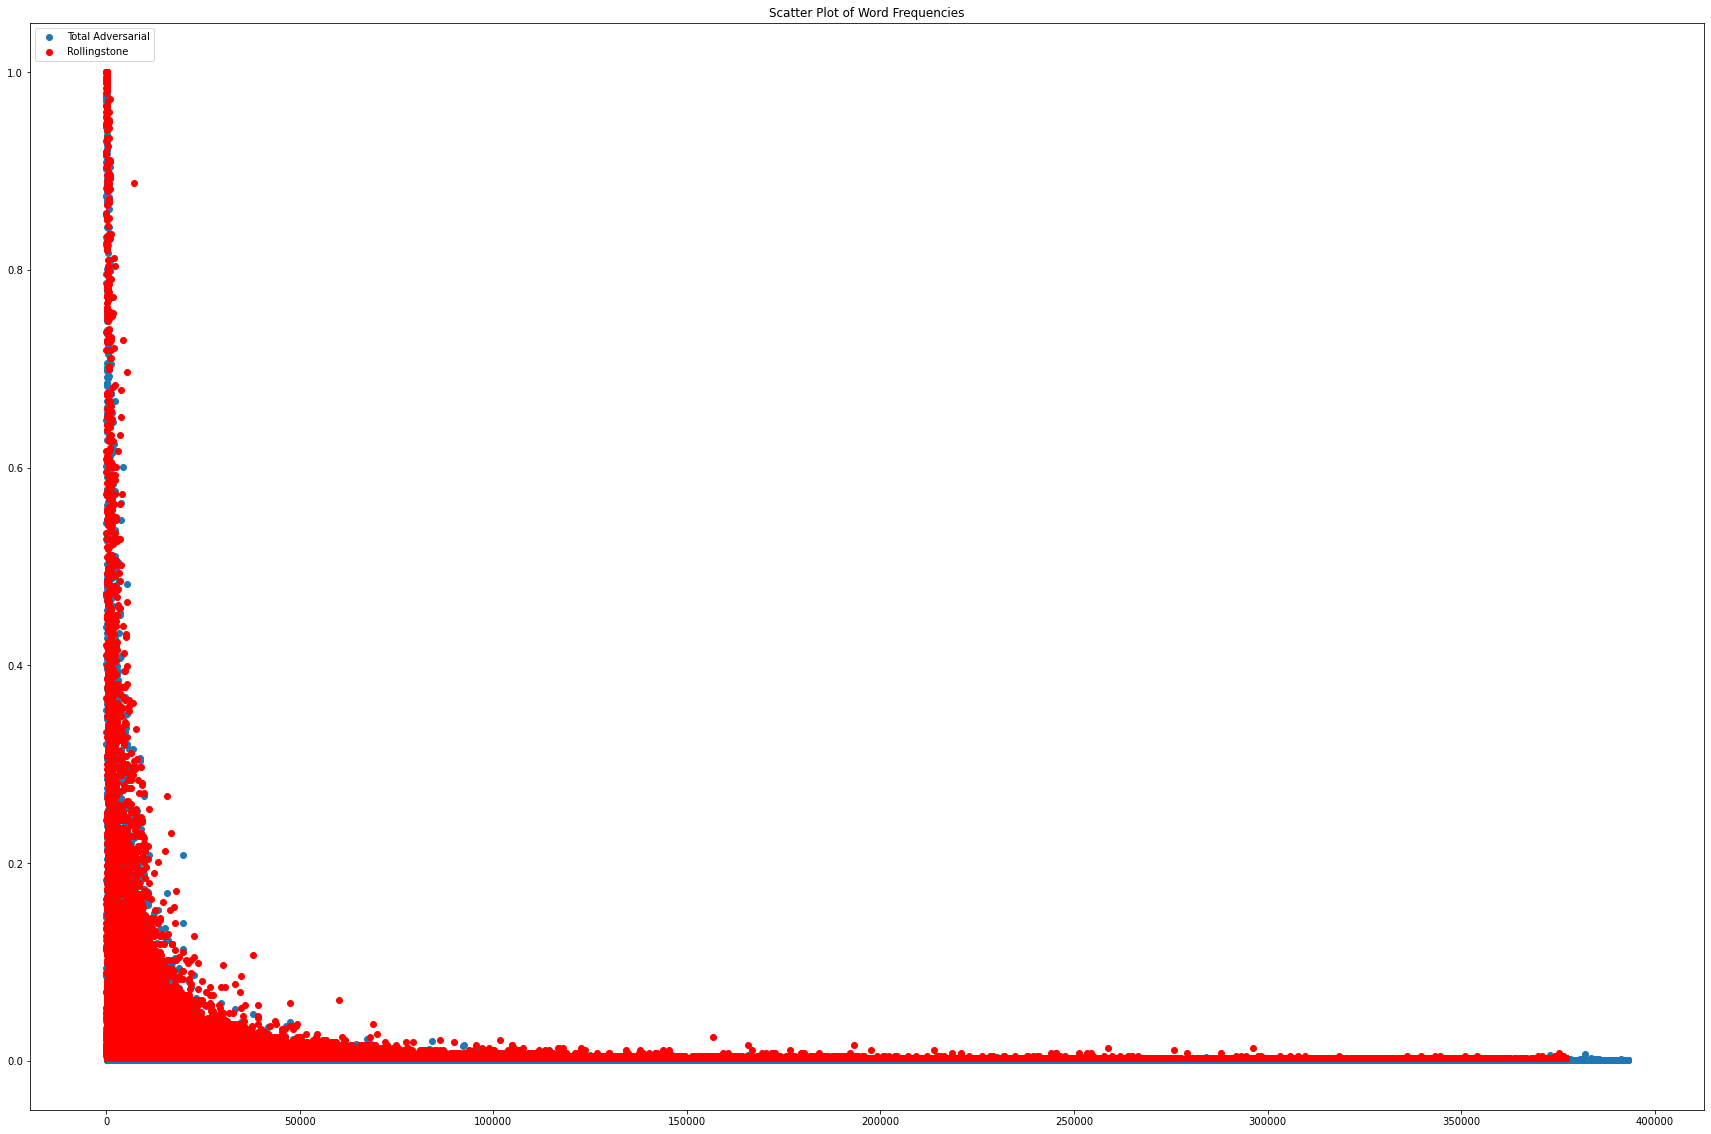

In [52]:
#average unique word occurrence counts for adversarial set as a whole and specifically rollingstone articles
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
total_word_averaged_counts = [x/len(sorted_total_adv) for x in list(zip(*counter.most_common()))[1]]
plt.scatter(list(zip(*counter.most_common()))[0], total_word_averaged_counts, label="Total Adversarial")
rolling_word_averaged_counts = [x/len(rolling_df) for x in list(zip(*rollingcounter.most_common()))[1]]
plt.scatter(list(zip(*rollingcounter.most_common()))[0], rolling_word_averaged_counts, color="red", label="Rollingstone")
plt.legend(loc='upper left');
plt.title("Scatter Plot of Averge Word Occurrence")
plt.show();

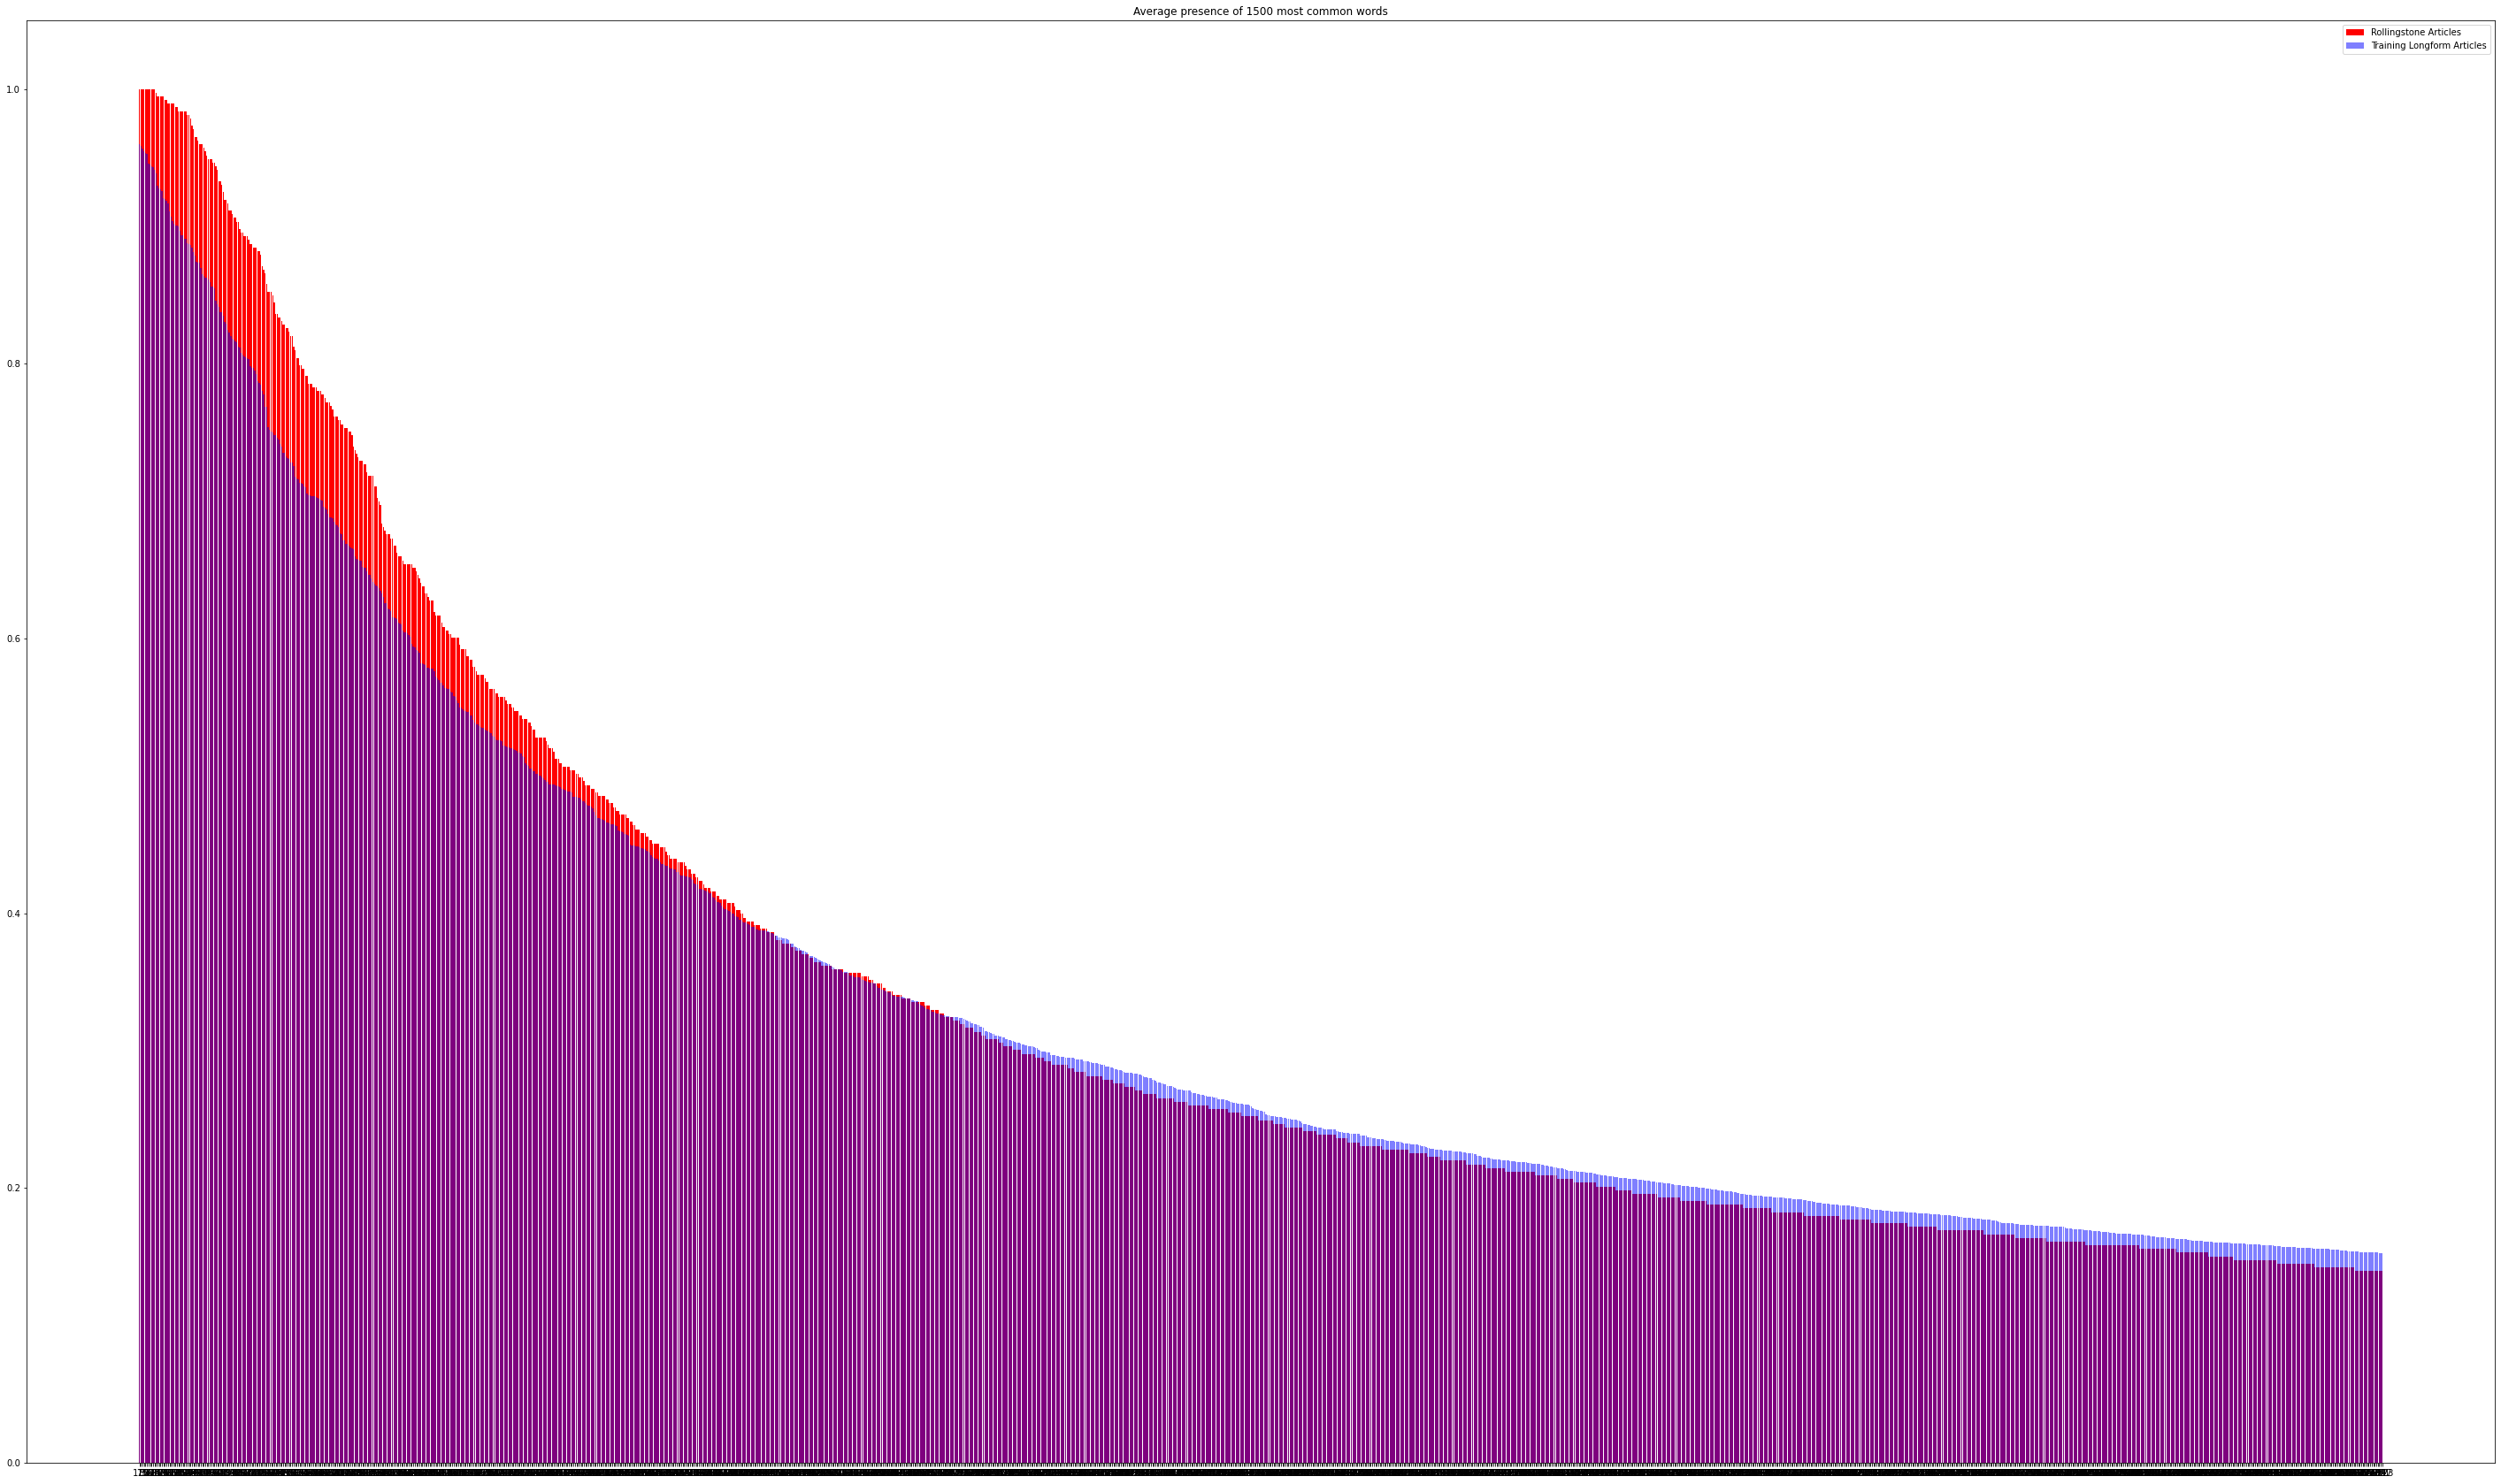

In [55]:
plt.figure(figsize=(50,30))
word_places = list(zip(*rollingcounter.most_common()))[0][:1500]
freqs = list(zip(*rollingcounter.most_common()))[1][:1500]
freqs = [x/(len(rolling_df)) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="red", label="Rollingstone Articles");
plt.xticks(x_pos, word_places);
word_places = list(zip(*longform_train_counter.most_common()))[0][:1500]
freqs = list(zip(*longform_train_counter.most_common()))[1][:1500]
freqs = [x/(longform_train_article_count) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="blue", label="Training Longform Articles", alpha=0.5);
plt.xticks(x_pos, word_places);
plt.legend(loc='upper right');
plt.title("Average presence of 1500 most common words")
plt.show();

In [56]:
#Getting inner product values from embedding multiplication with each word attribute
publication_emb = model.publication_embeddings.weight.data[0].cpu().numpy()
word_emb = model.attribute_emb_sum.weight.data.cpu().numpy()
word_emb.shape
inner_products = (publication_emb * word_emb).sum(axis=1)

(393146, 100)

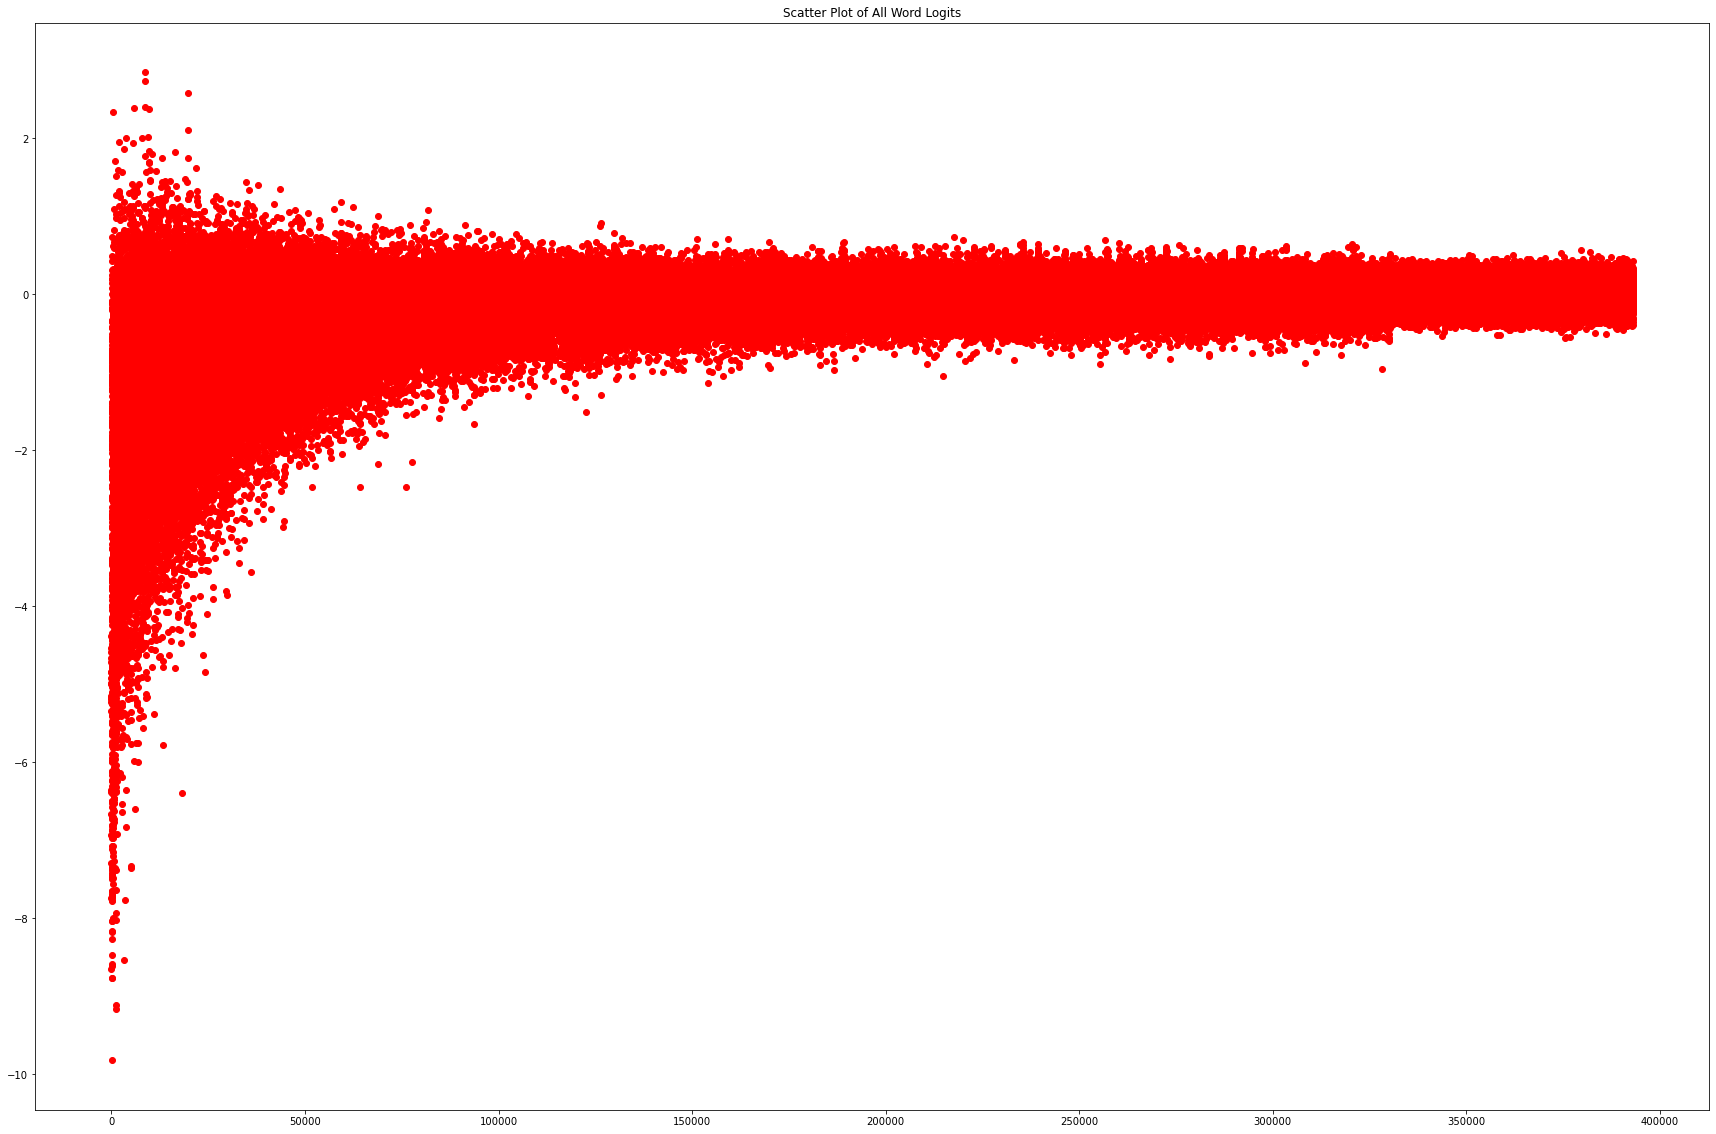

In [57]:
#scatter plot of all word logit values
plt.figure(figsize=(30,20))
plt.scatter(*zip(*enumerate(inner_products)), color="red")
plt.title("Scatter Plot of All Word Logits")
plt.show();

In [66]:
sorted_product_idx = np.argsort(inner_products)
most_weighted = []
least_weighted = []
for x in sorted_product_idx[-500:]:
    most_weighted.append((x, inner_products[x]))
for x in sorted_product_idx[:500]:
    least_weighted.append((x, inner_products[x]))
extreme_weighted = most_weighted + least_weighted

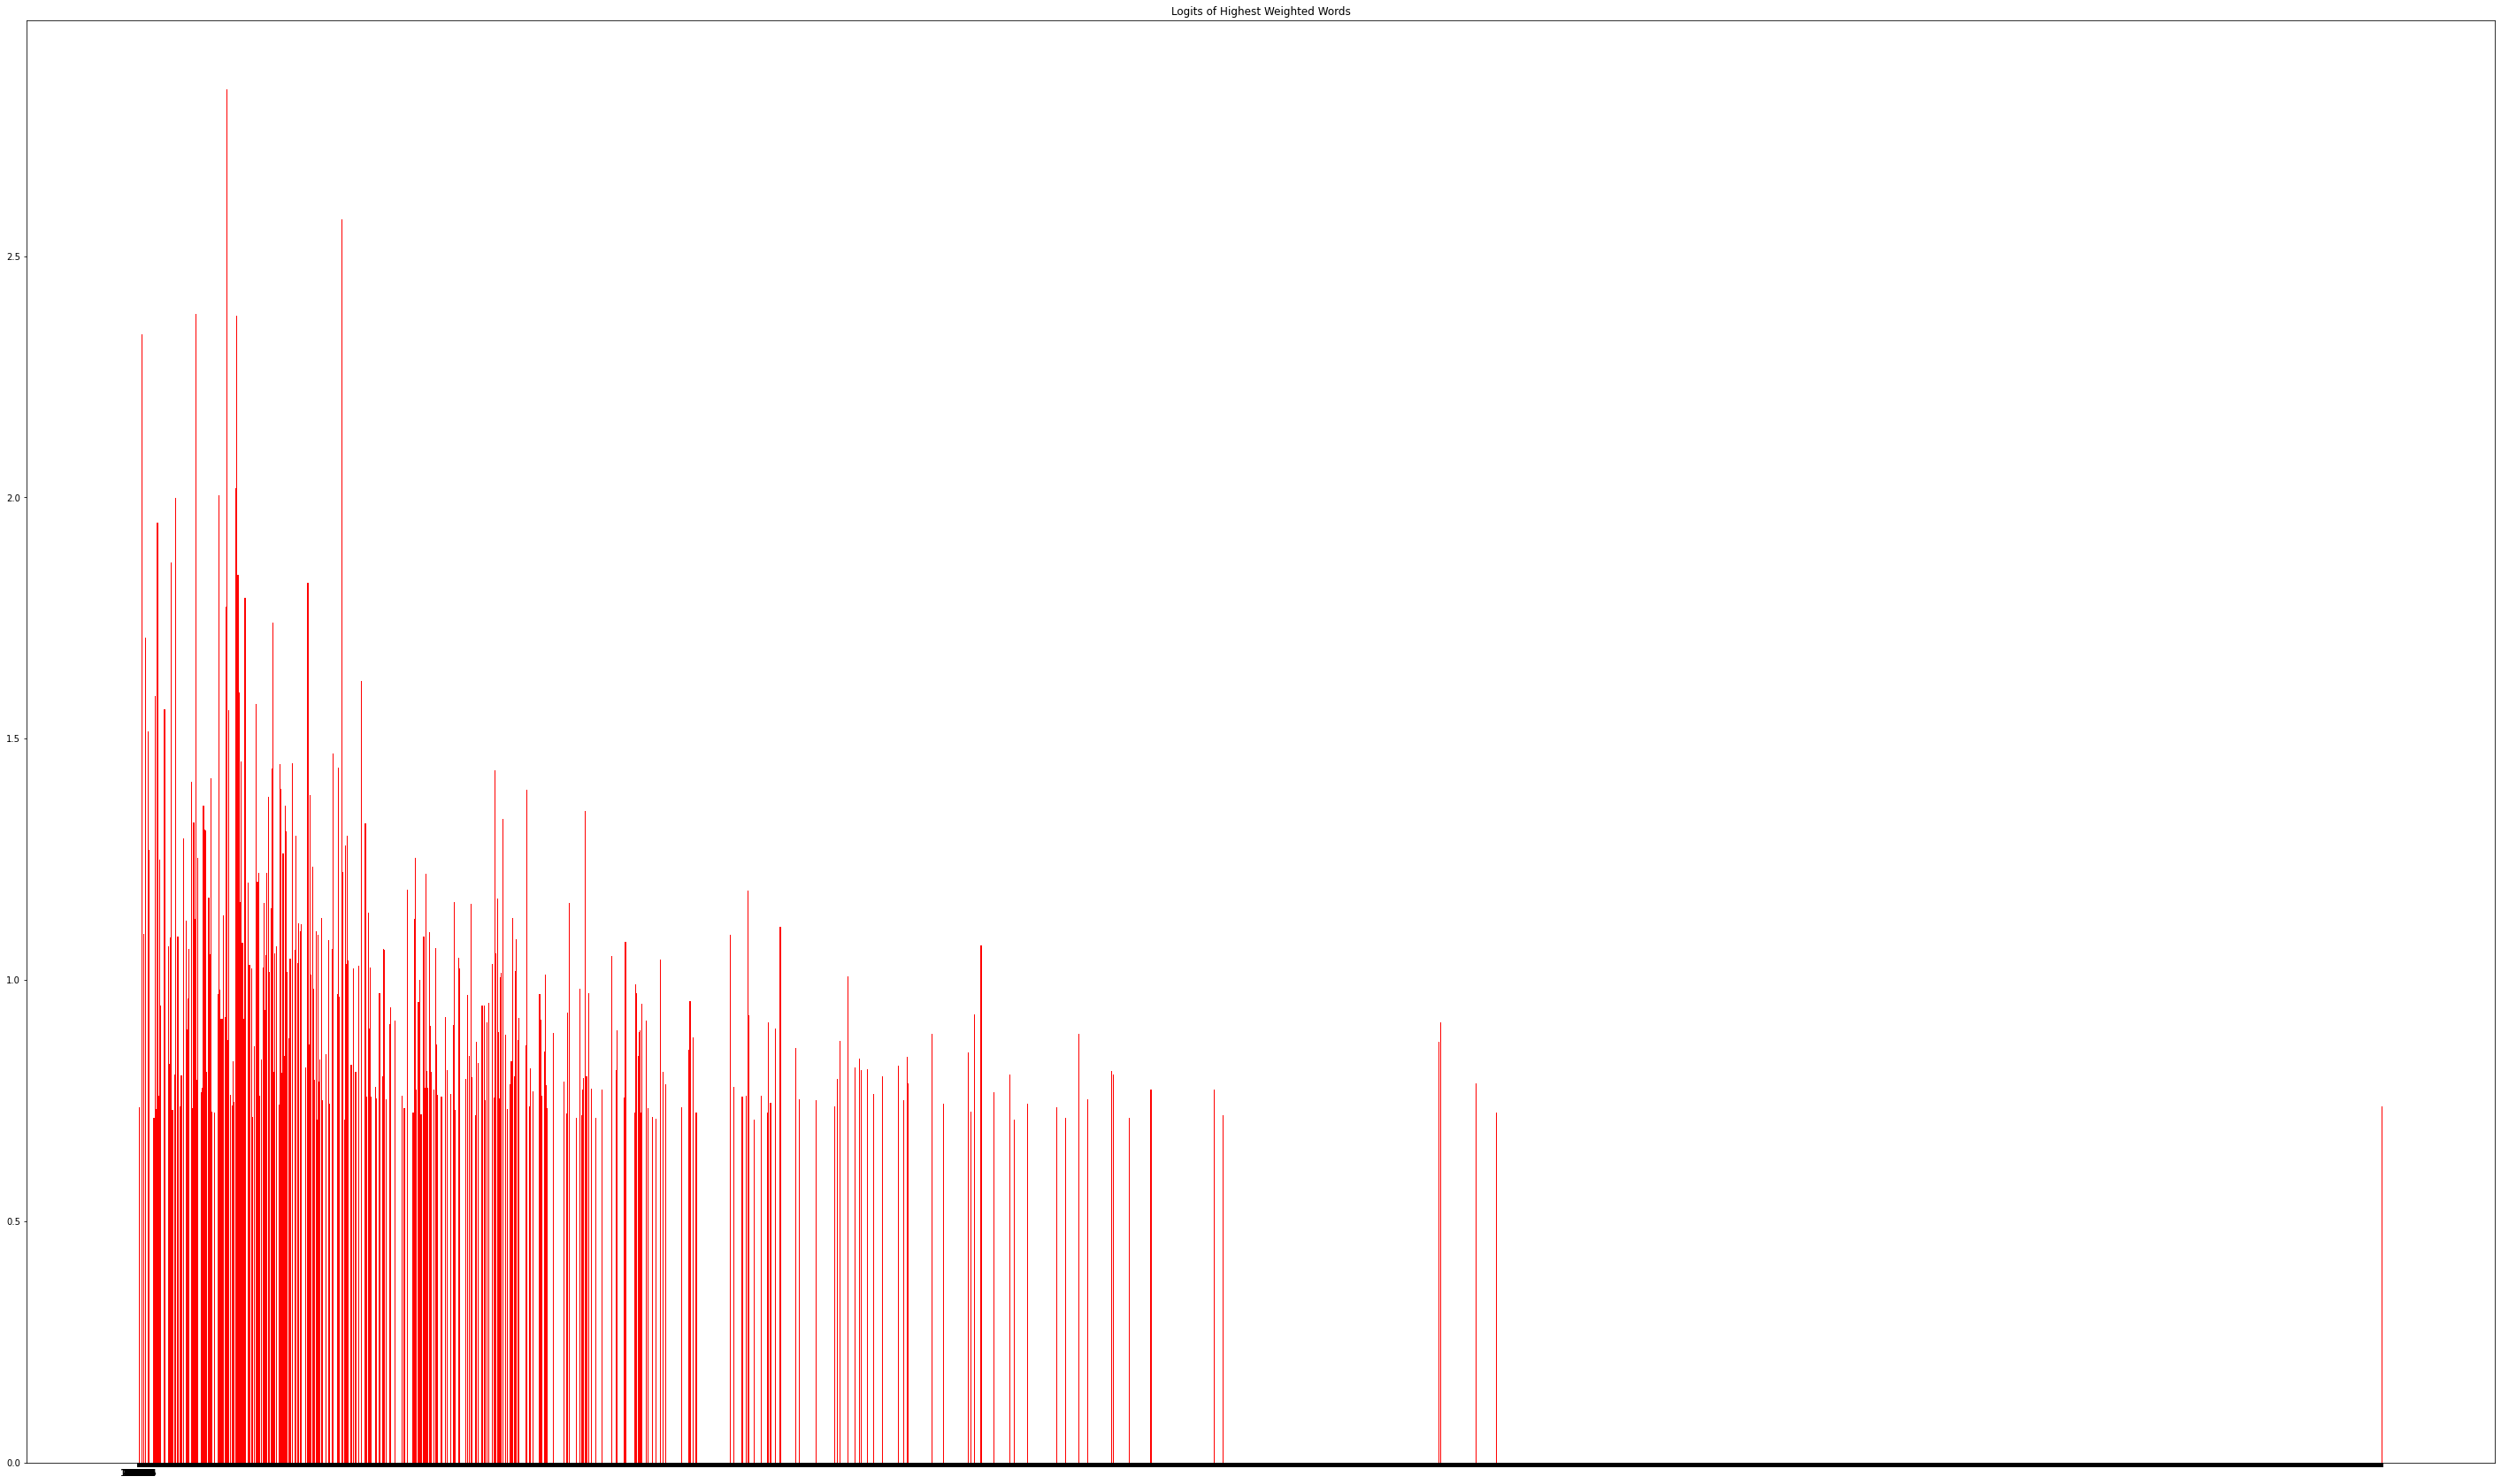

In [67]:
word_idx = list(zip(*most_weighted))[0]
weights = list(zip(*most_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Highest Weighted Words")
plt.xticks(x_pos, word_idx)
plt.show();

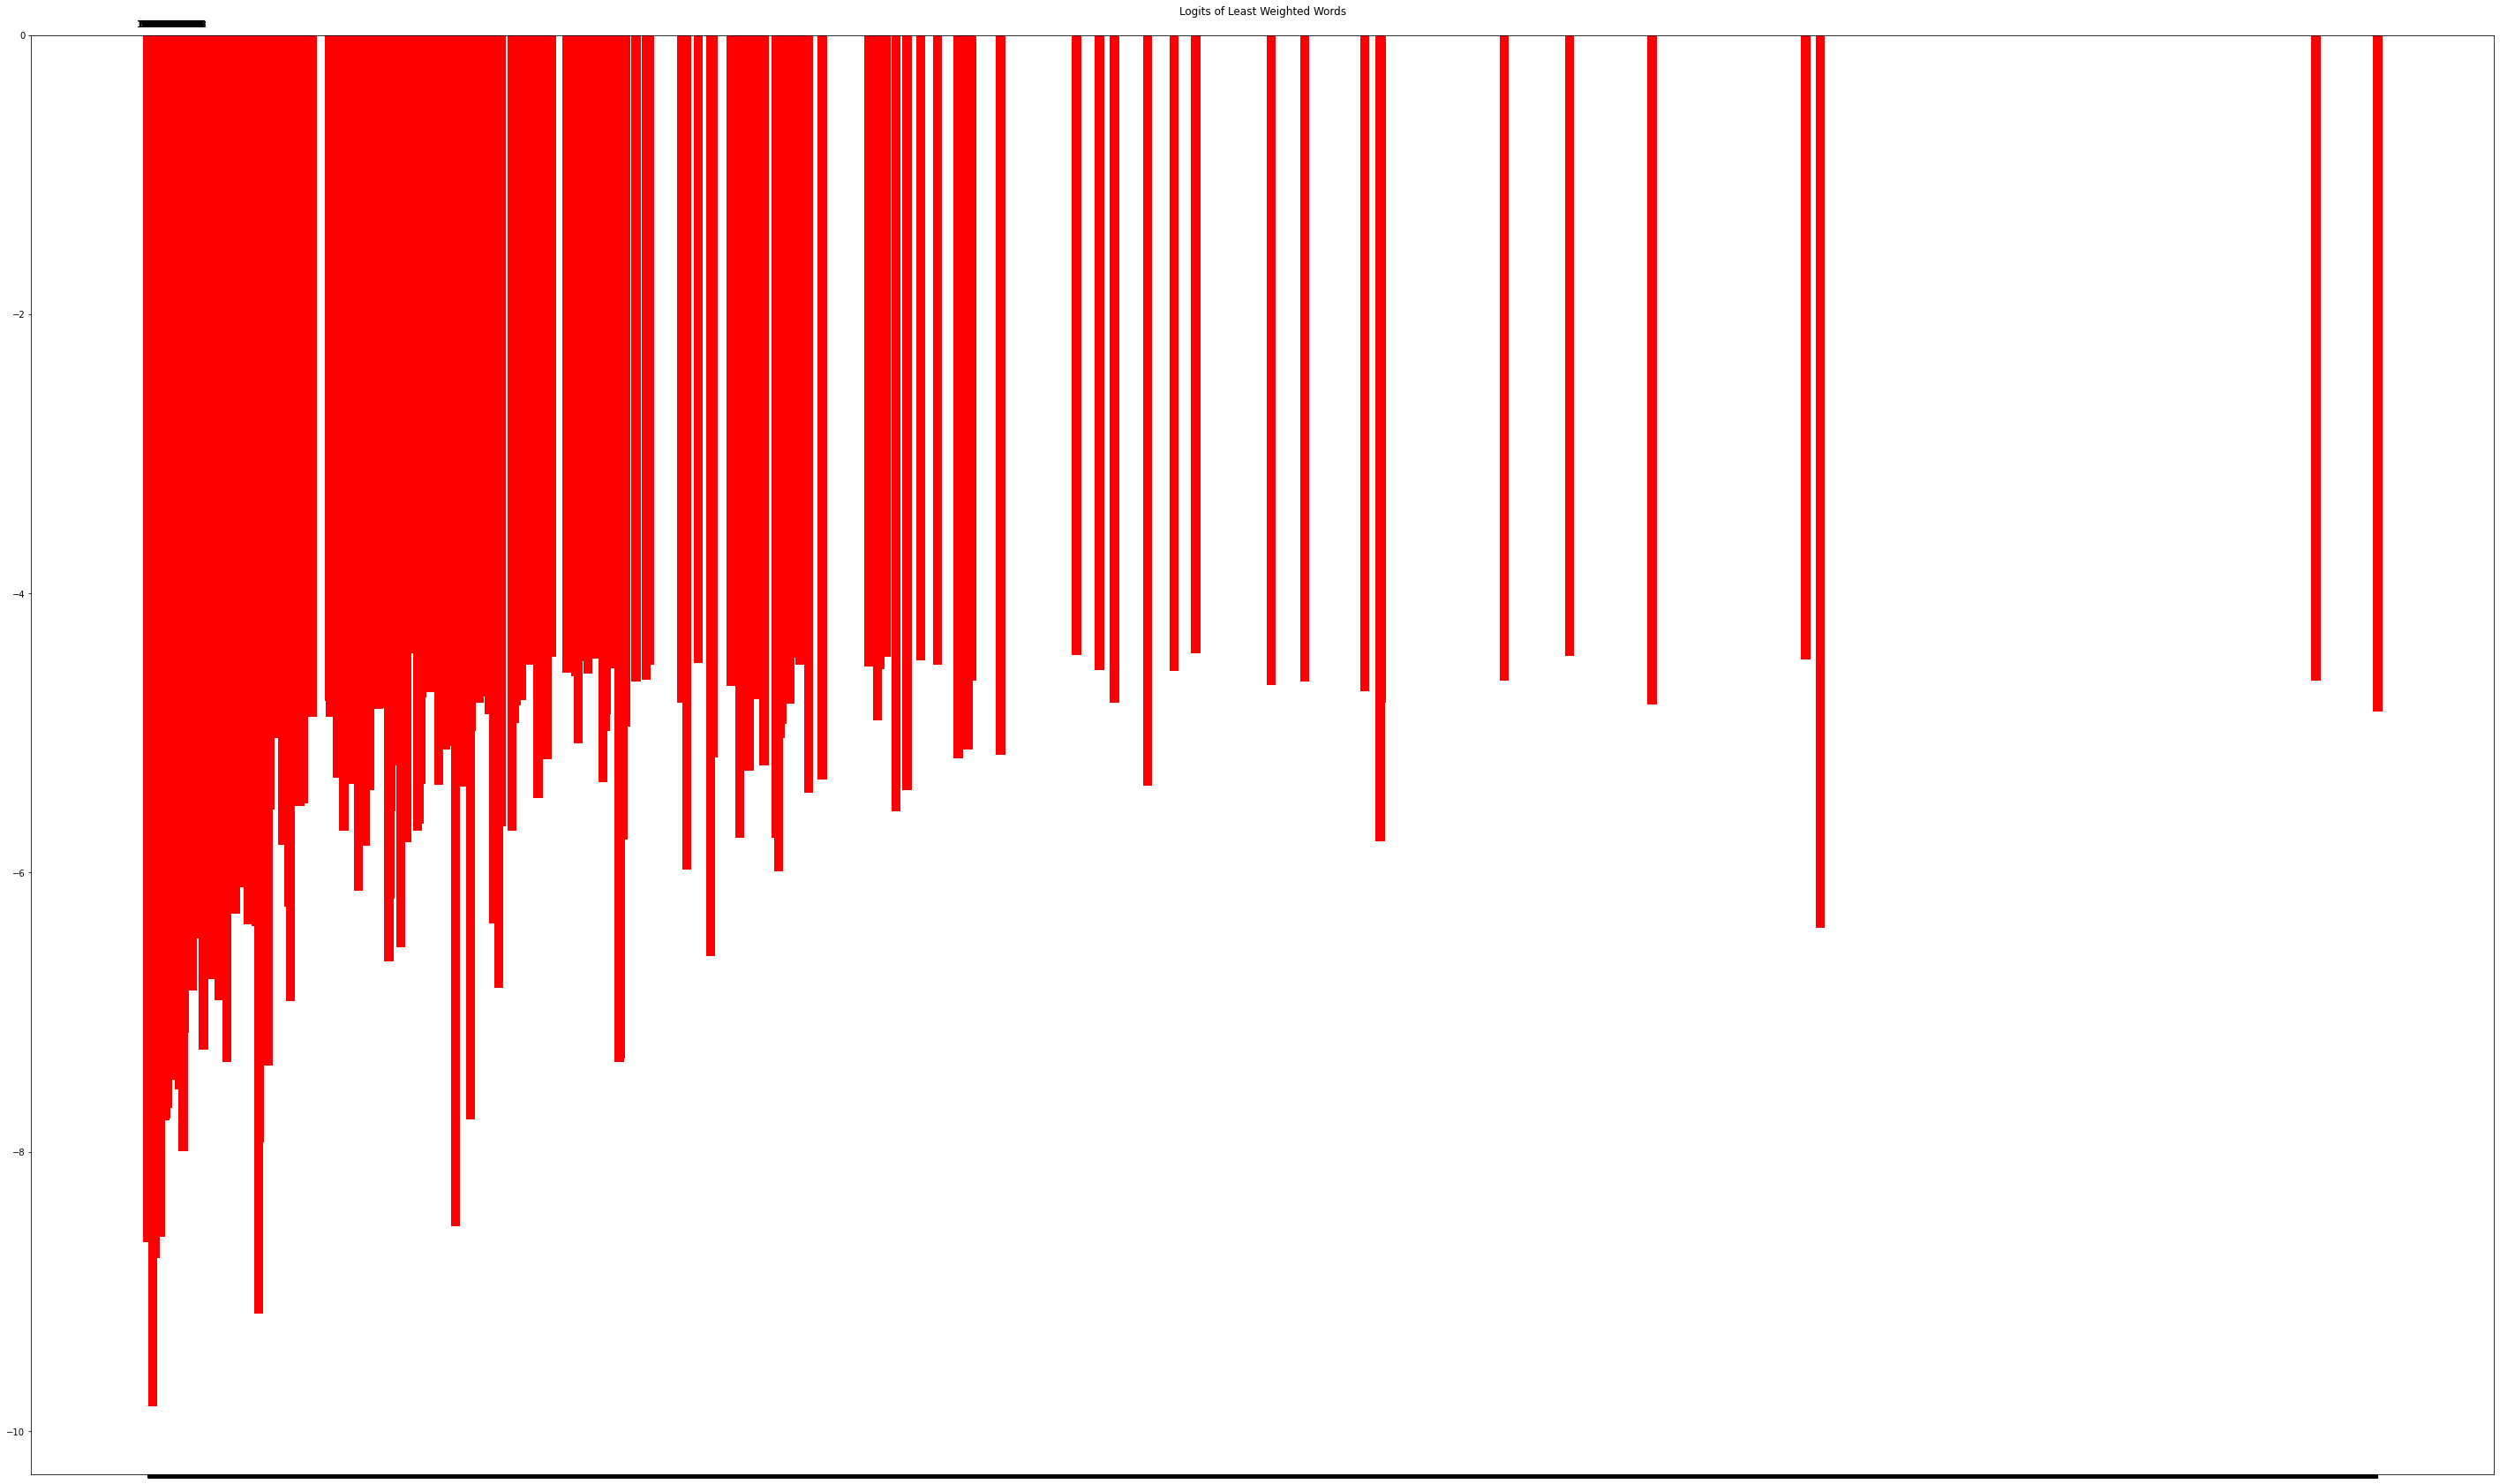

In [68]:
word_idx = list(zip(*least_weighted))[0]
weights = list(zip(*least_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Least Weighted Words")
plt.tick_params(labelbottom=False,labeltop=True)
plt.xticks(x_pos, word_idx)
plt.show();

In [60]:
print("Heaviest Weighted")
print("------------------------")
for x in sorted_product_idx[-50:]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Heaviest Weighted
------------------------
Word:  occasional   --------  1.3270594
Word:  wore   --------  1.3271022
Word:  torso   --------  1.333482
Word:  jammed   --------  1.3497349
Word:  dated   --------  1.360608
Word:  brush   --------  1.3615755
Word:  locks   --------  1.3790575
Word:  enlisted   --------  1.3827637
Word:  sixties   --------  1.3941745
Word:  haired   --------  1.395719
Word:  hadn   --------  1.4106184
Word:  printed   --------  1.4173436
Word:  concealed   --------  1.4353304
Word:  sixteen   --------  1.4389571
Word:  peered   --------  1.4404836
Word:  drank   --------  1.4478227
Word:  cent   --------  1.4489453
Word:  gray   --------  1.4522702
Word:  ribbons   --------  1.4626359
Word:  handsome   --------  1.4695
Word:  approached   --------  1.5144607
Word:  cluster   --------  1.5590327
Word:  sat   --------  1.561849
Word:  intricate   --------  1.572438
Word:  wondered   --------  1.5882355
Word:  hung   --------  1.5957072
Word:  busted   ------

In [61]:
sorted_product_idx = np.argsort(inner_products)
print("Least Weighted")
print("------------------------")
for x in sorted_product_idx[:50]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Least Weighted
------------------------
Word:  vox   --------  -9.820967
Word:  uncovering   --------  -9.157221
Word:  changing   --------  -9.108979
Word:  of   --------  -8.767943
Word:  a   --------  -8.762516
Word:  and   --------  -8.648215
Word:  but   --------  -8.608668
Word:  at   --------  -8.579564
Word:  pinterest   --------  -8.5344515
Word:  is   --------  -8.468267
Word:  as   --------  -8.267805
Word:  which   --------  -8.17182
Word:  more   --------  -8.168252
Word:  an   --------  -8.037553
Word:  have   --------  -8.030106
Word:  digital   --------  -8.025527
Word:  percent   --------  -7.993396
Word:  tuesday   --------  -7.9343634
Word:  t   --------  -7.7746825
Word:  photograph   --------  -7.765315
Word:  than   --------  -7.763073
Word:  to   --------  -7.743894
Word:  also   --------  -7.725244
Word:  read   --------  -7.7173414
Word:  for   --------  -7.713919
Word:  has   --------  -7.7107215
Word:  how   --------  -7.687468
Word:  the   --------  -7.65114

In [62]:
rollingcounts  = []
othercounts = []
for example in adv_data.examples:
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    if "rollingstone" in url:
        rollingcounts.append(len(list(set(example['text']))))
    else:
        othercounts.append(len(list(set(example['text']))))

In [63]:
rollingcounts = np.asarray(rollingcounts)
othercounts = np.asarray(othercounts)
print("Average Unique Words in Rollingstone Article: ", int(rollingcounts.mean()))
print("Average Unique Words in remaining adv data Articles: ", int(othercounts.mean()))

Average Unique Words in Rollingstone Article:  750
Average Unique Words in remaining adv data Articles:  324


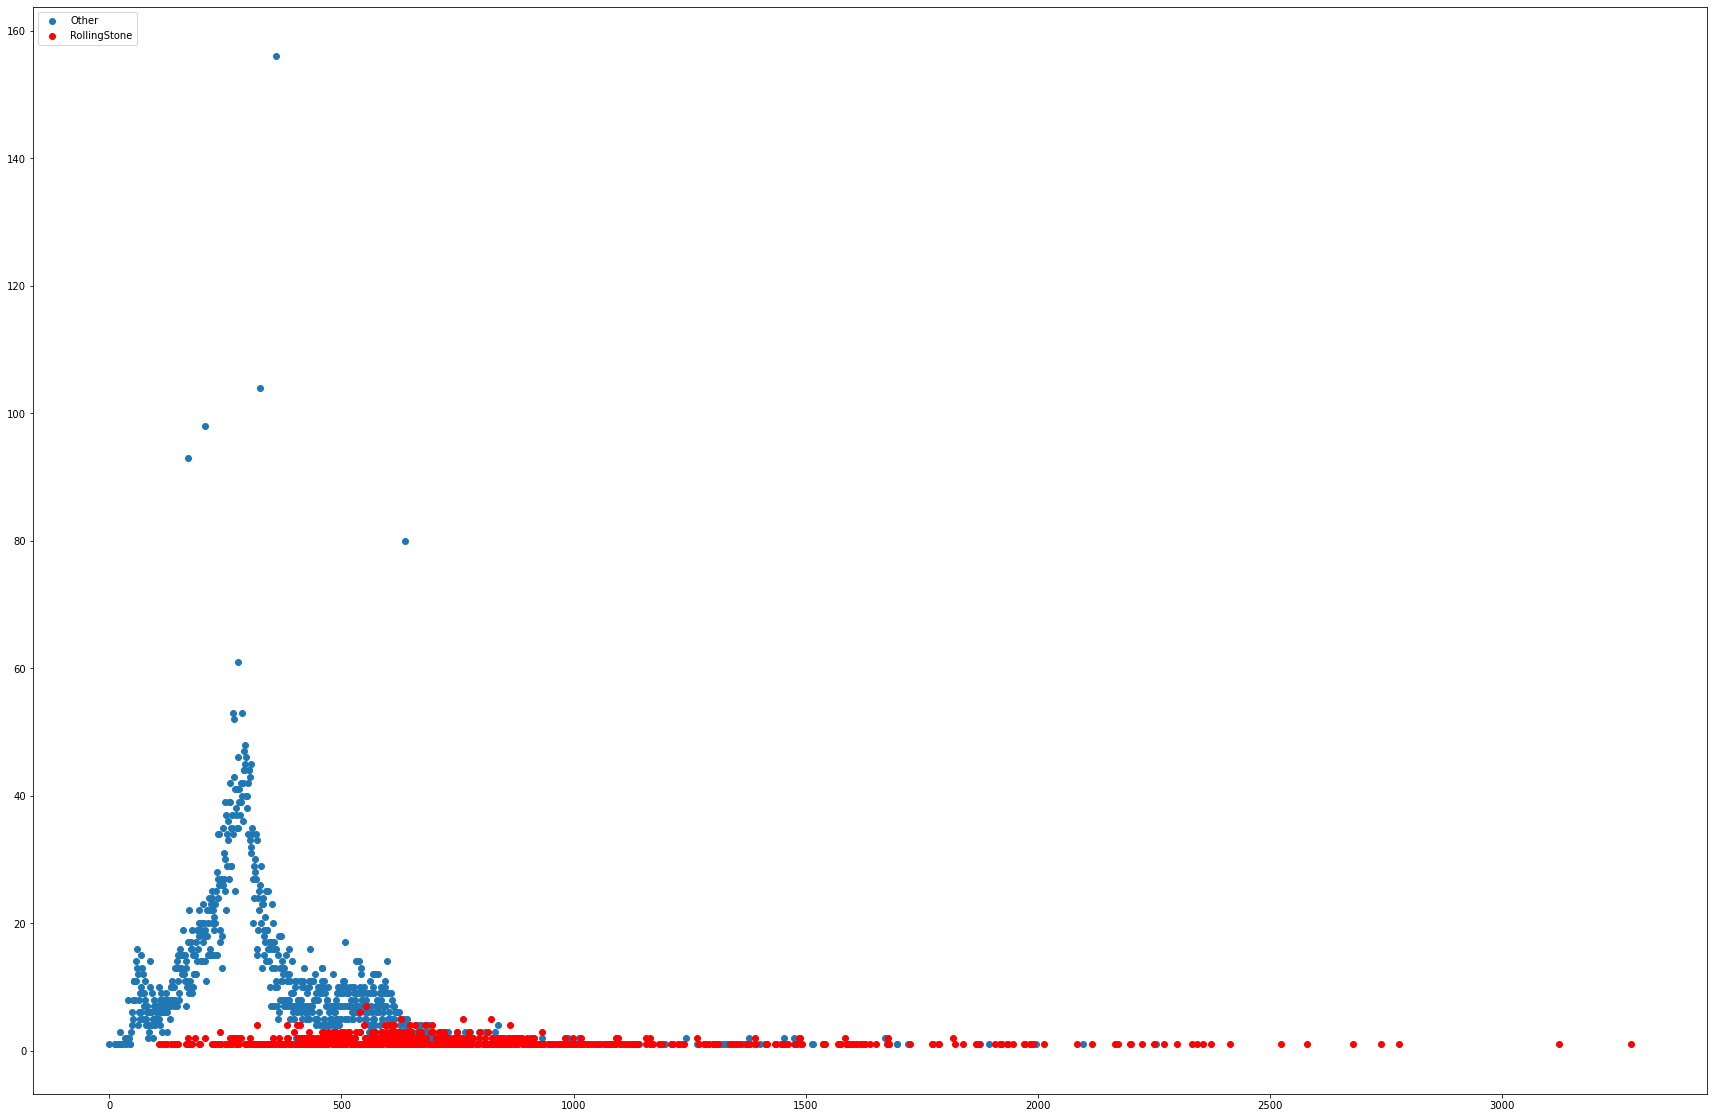

In [64]:
#Unique word counts for rollingstone articles compared to rest of adv_data
rolling_word_count_freq = collections.Counter()
rolling_word_count_freq.update(rollingcounts.tolist())
other_word_count_freq = collections.Counter()
other_word_count_freq.update(othercounts.tolist())

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*other_word_count_freq.most_common()), label="Other")
ax1.scatter(*zip(*rolling_word_count_freq.most_common()), color="red", label="RollingStone")
plt.legend(loc='upper left');
plt.show();

In [83]:
final_word_ids.get("stone")
inner_products[7213]

220

0.019772394

In [ ]:
for x,y in rollingcounter.most_common()[:100]:
    final=True
    for j,k in counter.most_common()[:100]:
        if x==j:
            final=False
            break
    if final:
        print(x)